### Image Correction
@author: N.Laanait  
@email: laanaitn@ornl.gov  
@date: 10/17/2016

This Notebook illustrates a straightforward workflow of correcting XRIM images (i.e. background substraction flat-field correction).  
Note that the effect of flat field correction on the diffraction contrast has not been fully investigated.  
Often times, it is best to just crop the image to remove any illumination spill through the beam stop.  
Currently this is an instrumental defficiency.  

In [2]:
%matplotlib notebook
import numpy as np
import os
from matplotlib import pyplot as plt
import h5py as h5
from PyXRIM.Viewer import stackViewFunc
from PyXRIM.Corrections import Corrector
from PyXRIM.PlotLib import imageGallery

In [13]:
# open h5file
wdir = os.getcwd()
fname = '/home/nl7/work/xray_data/BFO_TSO_20160330.hdf5'
fpath = os.path.join(wdir, fname)
f = h5.File(fpath, 'r')
# f.items()

In [14]:
# Get Correction Files
metag = f['BFO_TSO_1/Meta']
READ = metag['READ']
DARK = metag['DARK']

In [15]:
# plot corrdet
rawg = f['BFO_TSO_2/Raw']
dset = rawg['S008']
dset.attrs['scan_command']
# L = dset.attrs['DAC5']
# Int = dset.attrs['corrdet']
# fig = plt.figure(figsize = (8,8))
# plt.plot(L-0.004,np.log10(Int), marker = 'o')
# plt.xlabel('L ($DyScO_3 [113]_{pc}$ (r.l.u))',fontsize = 18)
# plt.ylabel('$\log$ (Intensity)  (arb. units)', fontsize = 18)
# plt.xticks(fontsize = 18)
# plt.yticks(fontsize = 18)

'loopscan 500 2 0'

(-0.5, 2047.5, 2047.5, -0.5)

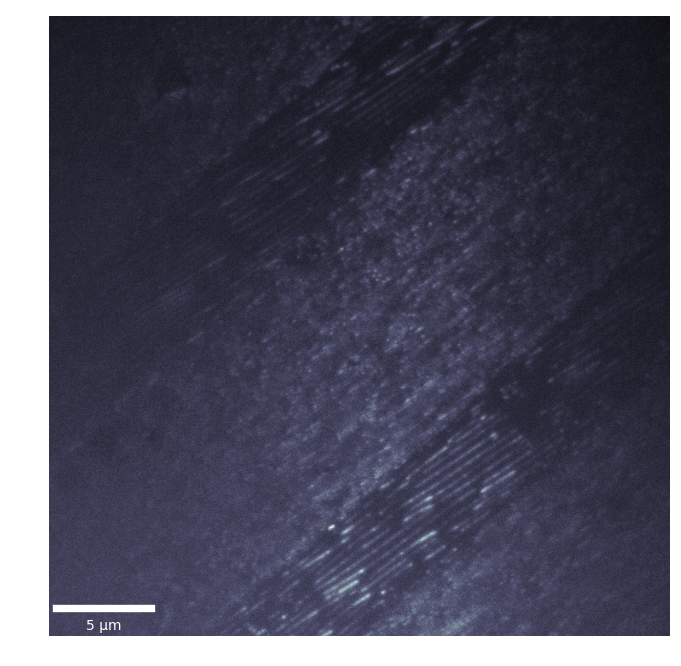

In [245]:
# %matplotlib qt
fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.imshow(dset[5],cmap = 'bone')
scalebar = ScaleBar(15e-9, 0.2,color ='w')
ax.add_artist(scalebar)
ax.axis('off')

In [16]:
cr = Corrector()
cr.loadData(dset)
bkgData = cr.bkgSubtract(READ,DARK)
normData = cr.normalize(monitor=None, trans = 'trans', use_processed=True)

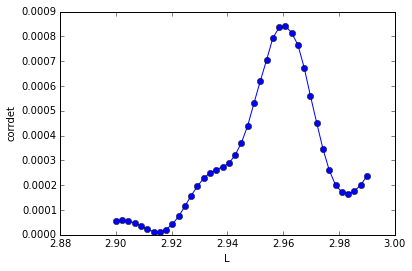

In [10]:
# plot average
Int_raw = np.sum(dset[:,800:1200,800:1200],axis=(1,-1))
Int_bkg = np.mean(bkgData,axis=(1,-1))
Int_norm = np.mean(normData[:,800:1200,800:1200],axis=(1,-1))
fig = plt.figure()
plt.plot(
            L, Int_norm,
#          L,dset.attrs['D3']/dset.attrs['seconds'], 
#          L, dset.attrs['imroi1']/dset.attrs['seconds'],
         marker = 'o')
plt.xlabel('L')
plt.ylabel('Intensity')

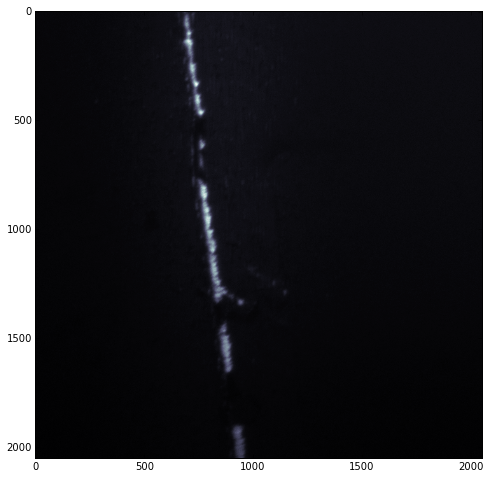

In [43]:
# %matplotlib qt
plt.figure(figsize = (8,8))
plt.imshow(normData[25],cmap = 'bone')
# imageGallery(4,4,'',normData, cmap = 'bone')
# plt.show()

In [317]:
cr.loadprocData(dset[:5])

In [334]:
# flatfield correction
flatData = cr.flatField(34,sigmaMorph=120,radiusMorph=0, method='lowpass filter', winLP=3, use_processed= True)

launching 34 kernels...
Extracting Flattened Images...
Closing down the kernels... 



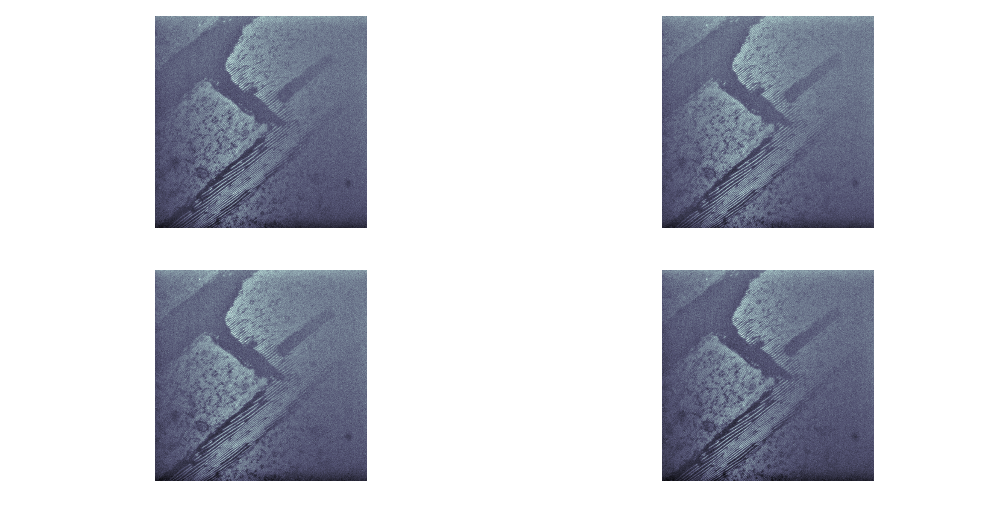

In [303]:
imageGallery(2,2,'',flatData, cmap = 'bone')

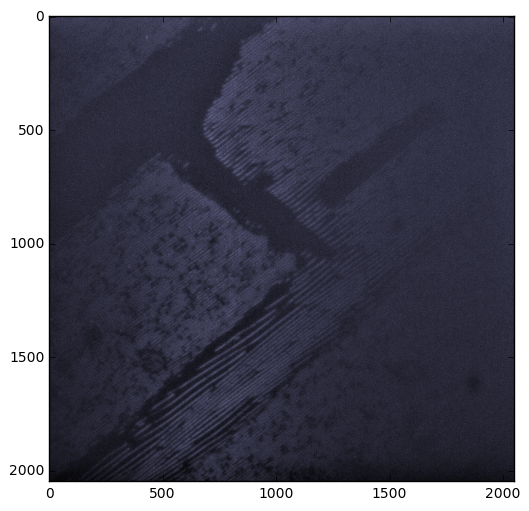

In [308]:
plt.figure(figsize = (6,6))
plt.imshow(flatData[5],cmap = 'bone')

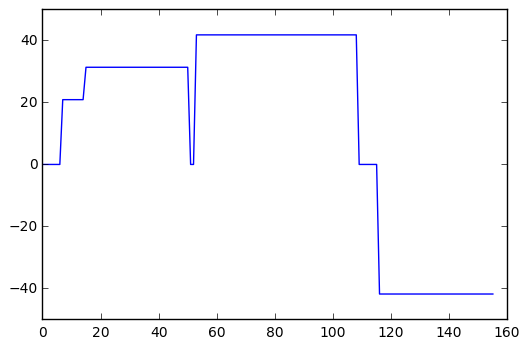

In [143]:
# v_vals = np.zeros(shape=(156,))
# v_vals[:7] = 0
# v_vals[7:15] = 10.*10/4.785
# v_vals[15:51] = 15.*10/4.785
# v_vals[53:109] = 20.*10/4.785
# v_vals[109:116] = 0
# v_vals[116:] = -20.*10/4.785
# plt.plot(v_vals)

In [324]:
[imp.mean() for imp in flatData]

[1974.3065808476629,
 1971.1336782177134,
 1971.6628033953764,
 1970.886942989878,
 1971.36532809459]

In [351]:
from scalebar import ScaleBar
from time import sleep
wdir = os.getcwd()
for ((i,imp), time, field) in zip(enumerate(flatData), dset.attrs['Time'], dset.attrs['DAC5']):
    fig, ax = plt.subplots(1,1, figsize = (6,6))
#     imp = imp*1e6
#     imp = np.log(imp)
# #     imp[imp <= 0] = 1
    ax.imshow(imp[600:1600, 400:1400],cmap = 'bone', vmax = imp.mean()*1.45)
    scalebar = ScaleBar(15e-9, 0.2,color ='w')
    ax.add_artist(scalebar)
    label = "E = %2.2f kV cm$^{-1}$ \ntime = %d ms" %(field*1e2/4.785,time)
    ax.axis('off')
    plt.text(10,90,label, fontsize = 12, color='w')
    plt.close()
#     plt.show()
    path = os.path.join(wdir,'folder/S008_%d.png'%(i))
    fig.savefig(path, dpi=120, frameon=False, transparent=True)
#     sleep(2)

In [128]:
plt.close('all')

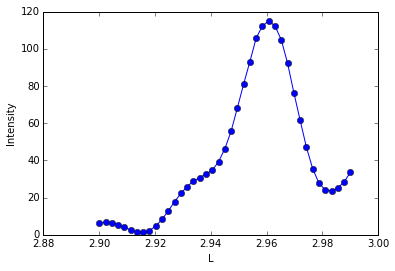

In [28]:
# plot average
Int_flat = np.sum(flatData[:, 800:1200,800:1200],axis=(1,-1))
fig = plt.figure()
plt.plot(
            L, Int_flat,
#          L,dset.attrs['D3']/dset.attrs['seconds'], 
#          L, dset.attrs['imroi1']/dset.attrs['seconds'],
         marker = 'o')
plt.xlabel('L')
plt.ylabel('Intensity') 

In [17]:
f.close()

In [19]:
# Write data into h5-file
with h5.File(fpath, 'r+') as f:
#     rawg = f['BFO_TSO_1/Raw']
    rawg = f['BFO_TSO_2/Raw']
    dset = rawg['S008']
    procg = f['BFO_TSO_2/Process']
    dsetname = 'S008_normalized'
    dsetnew = procg.create_dataset(dsetname, data = normData , dtype =np.float64,
                                    compression = 'lzf')
    dset.attrs['normalized']=dsetnew.ref

In [22]:
normset = f[dset.attrs['normalized']]
normset.write_direct(normData)

In [29]:
flatset = f[dset.attrs['flatfield']]
flatset.write_direct(flatData)

In [30]:
f.close()